# Brain Encoding: Predicting Brain Activity from RL Agent

**Goal:** Use CNN activations to predict BOLD activity.

**Pipeline:** Load data → Align → PCA → Ridge regression → Compare layers

In [1]:
# @title Environment Setup
# @markdown Run this cell to set up the environment and download the necessary data.

import os
import sys
import subprocess
from pathlib import Path

# Configuration
REPO_URL = "https://github.com/courtois-neuromod/mario.tutorials.git"
PROJECT_PATH = Path("/content/mario.tutorials")
REQUIREMENTS_FILE = "notebooks/03_requirements.txt"
SUBJECT = "sub-01"
SESSION = "ses-001"
TR = 1.49
DOWNLOAD_STIMULI = True

def run_shell(cmd):
    print(f"Running: {cmd}")
    subprocess.check_call(cmd, shell=True)

# Detect Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("🚀 Detected Google Colab. Setting up ephemeral environment...")
    
    # 1. Clone Repository
    if not PROJECT_PATH.exists():
        run_shell(f"git clone {REPO_URL} {PROJECT_PATH}")
    else:
        run_shell(f"cd {PROJECT_PATH} && git pull")
    
    os.chdir(PROJECT_PATH)
    sys.path.insert(0, str(PROJECT_PATH / "src"))
    
    # 2. Run Setup
    from setup_utils import setup_project
    setup_project(REQUIREMENTS_FILE, SUBJECT, SESSION, download_stimuli_flag=DOWNLOAD_STIMULI)

else:
    print("💻 Detected Local Environment.")
    if Path.cwd().name == 'notebooks':
        os.chdir(Path.cwd().parent)
    sys.path.insert(0, str(Path.cwd() / "src"))
    print(f"✅ Ready. Working directory: {os.getcwd()}")

💻 Detected Local Environment.
✅ Ready. Working directory: /home/hyruuk/GitHub/neuromod/mario_analysis/mario.tutorials


In [2]:
# Silent Setup
try:
    from setup_utils import setup_all
    # Ensure data is available (silently checks)
    setup_all(subject="sub-01", session="ses-010")
except ImportError:
    print("Setup utils not found. Please ensure src is in path.")
except Exception as e:
    print(f"Setup warning: {e}")


Setup utils not found. Please ensure src is in path.


In [3]:
# Setup - imports and configuration

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Add src to path
src_dir = Path('..') / 'src'
sys.path.insert(0, str(src_dir))

# Import utilities
from utils import (
    get_sourcedata_path,
    load_events,
    get_session_runs,
    get_bold_path,
    load_bold
)

# Import RL utilities
from rl_utils import (
    create_simple_proxy_features,
    convolve_with_hrf,
    apply_pca
)

# Import RL visualizations
from rl_viz_utils import (
    plot_pca_variance_per_layer,
    plot_layer_activations_sample
)

# Import encoding utilities
from encoding_utils import (
    load_and_prepare_bold,
    fit_encoding_model_per_layer,
    compare_layer_performance
)

# Import encoding visualizations
from encoding_viz_utils import (
    plot_layer_comparison_bars,
    plot_r2_brainmap
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Get sourcedata path
sourcedata_path = get_sourcedata_path()

print("✓ Setup complete!")

✓ Setup complete!


## Encoding Model

**Approach:** Ridge regression with PCA-reduced CNN features.

**Why ridge?** Efficient, prevents overfitting, interpretable.

In [4]:
# Load prerequisites

from nilearn.masking import compute_multi_epi_mask

# Get runs
runs = get_session_runs(SUBJECT, SESSION, sourcedata_path)
print(f"Found {len(runs)} runs: {runs}")

# Load events
all_events = []
for run in runs:
    events = load_events(SUBJECT, SESSION, run, sourcedata_path)
    all_events.append(events)
    print(f"  {run}: {len(events)} events")

# Load BOLD images and paths
print("\nLoading BOLD data...")
bold_imgs = []
bold_paths = []
for run in runs:
    bold_path = get_bold_path(SUBJECT, SESSION, run, sourcedata_path)
    bold_img = load_bold(SUBJECT, SESSION, run, sourcedata_path)
    bold_paths.append(str(bold_path))  # Convert Path to string for nilearn
    bold_imgs.append(bold_img)

# Create common mask
print("\nCreating common brain mask...")
common_mask = compute_multi_epi_mask(bold_imgs, n_jobs=1)
n_voxels = int((common_mask.get_fdata() > 0).sum())
print(f"✓ Common mask: {n_voxels:,} voxels")

print("\n✓ All prerequisites loaded!")

Found 4 runs: ['run-1', 'run-2', 'run-3', 'run-4']
  run-1: 712 events
  run-2: 1032 events
  run-3: 1037 events
  run-4: 1030 events

Loading BOLD data...

Creating common brain mask...
✓ Common mask: 213,371 voxels

✓ All prerequisites loaded!


## Loading Data

Loading: BOLD images (4 runs), events, brain mask

In [5]:
# Load and align activations from replays

# First, check if we have a trained model
from pathlib import Path

MODEL_DIR = Path('models/')
MODEL_PATH = MODEL_DIR / 'mario_ppo_agent.pth'

if not MODEL_PATH.exists():
    print(f"✗ No trained model found at: {MODEL_PATH}")
    print("\nYou need a trained RL agent to extract activations.")
    print("Please train an agent first by running:")
    print("  python ../train_mario_agent.py --steps 5000000")
    print("\n⚠ Cannot proceed with encoding analysis without trained model")
    HAS_MODEL = False
else:
    print(f"✓ Found trained model: {MODEL_PATH}")
    HAS_MODEL = True
    
    # Load the model
    from rl_utils import load_pretrained_model, align_activations_to_bold
    
    print("\nLoading model...")
    model = load_pretrained_model(MODEL_PATH, device='cpu')
    print("✓ Model loaded")
    
    # Align activations to BOLD
    # This will:
    # 1. Load replay files for each game segment
    # 2. Extract RL activations at 60Hz  
    # 3. Downsample to TR (1.49s)
    # 4. Apply HRF convolution
    # 5. Create NaN mask for non-gameplay periods
    
    alignment_results = align_activations_to_bold(
        model=model,
        subject=SUBJECT,
        session=SESSION,
        runs=runs,
        sourcedata_path=sourcedata_path,
        tr=TR,
        device='cpu',
        apply_hrf=True,  # Apply HRF convolution
        bold_imgs=bold_imgs  # Pass BOLD images for exact TR count
    )
    
    # Extract results
    layer_activations = alignment_results['activations']
    valid_mask = alignment_results['mask']
    run_info = alignment_results['run_info']
    
    print(f"\n{'='*70}")
    print("Alignment summary:")
    for info in run_info:
        print(f"  {info['run']}: {info['n_valid_trs']}/{info['n_trs']} TRs "
              f"({info['n_segments']} game segments)")
    print(f"{'='*70}\n")

✓ Found trained model: models/mario_ppo_agent.pth

Loading model...
✓ Model loaded

Aligning RL activations to BOLD for sub-01 ses-001


Processing run-1:
--------------------------------------------------
  Found 11 game trial(s)
  Using actual BOLD length: 451 TRs

  Repetition 0: Level1-1
    Onset: 0.01s, Duration: 86.55s
  Loading replay: sub-01_ses-001_task-mario_level-w1l1_rep-000.bk2
    Level format: Level1-1 -> Level1-1
  Processing 4419 frames...
    Extracted 4419 frames → downsampling to TR...
    → 59 TRs (indices 0-59)

  Repetition 1: Level1-1
    Onset: 86.56s, Duration: 71.11s
  Loading replay: sub-01_ses-001_task-mario_level-w1l1_rep-001.bk2
    Level format: Level1-1 -> Level1-1
  Processing 3906 frames...
    Extracted 3906 frames → downsampling to TR...
    → 48 TRs (indices 58-106)

  Repetition 2: Level1-1
    Onset: 157.68s, Duration: 43.15s
  Loading replay: sub-01_ses-001_task-mario_level-w1l1_rep-002.bk2
    Level format: Level1-1 -> Level1-1
  Processing 22

## Loading RL Activations

Extracting CNN activations from replay files → downsampling to TR → applying HRF

## Load Cached Results (if available)

Check if we have already computed results. If yes, load them and skip all processing!

In [6]:
# Check if cached results exist and load if available

from atlas_encoding_utils import load_complete_results, check_complete_results_exist

# Define cache file path
CACHE_DIR = Path('derivatives/encoding_results')
CACHE_FILE = CACHE_DIR / f'{SUBJECT}_{SESSION}_complete_results.pkl'

# Try to load cached results
cached_results = load_complete_results(CACHE_FILE)

if cached_results is not None:
    # Extract all variables from cache
    parcel_bold = cached_results['parcel_bold']
    all_pca_results = cached_results['all_pca_results']
    all_encoding_results = cached_results['all_encoding_results']
    train_indices = cached_results['train_indices']
    test_indices = cached_results['test_indices']
    valid_mask_cached = cached_results['valid_mask']

    # Reconstruct atlas (we only saved labels)
    from atlas_encoding_utils import load_schaefer_atlas
    atlas = load_schaefer_atlas(n_rois=400, yeo_networks=7)
    atlas['labels'] = cached_results['atlas_labels']

    # Set PCA dims from metadata
    pca_dims = cached_results['metadata']['pca_dims']

    # Set flag to skip processing
    USE_CACHED_RESULTS = True

    print("\n⚡ USING CACHED RESULTS - ALL PROCESSING SKIPPED! ⚡")
    print(f"\nTo force recomputation, delete: {CACHE_FILE}\n")
else:
    print("\n📊 No cache found - will process from scratch and save results")
    print(f"Results will be saved to: {CACHE_FILE}\n")
    USE_CACHED_RESULTS = False


📊 No cache found - will process from scratch and save results
Results will be saved to: derivatives/encoding_results/sub-01_ses-001_complete_results.pkl



In [7]:
# Load Schaefer 400 atlas and extract parcel-averaged BOLD

if not USE_CACHED_RESULTS:
    from atlas_encoding_utils import load_schaefer_atlas, extract_parcel_bold
    from nilearn.interfaces.fmriprep import load_confounds

    print("Loading Schaefer 400 atlas...")
    atlas = load_schaefer_atlas(n_rois=400, yeo_networks=7)
    print(f"✓ Loaded: {len(atlas['labels'])} parcels\n")

    # Load confounds for each run
    print("Loading confounds...")
    confounds_list = []
    for bold_path in bold_paths:
        confounds, _ = load_confounds(
            bold_path,
            strategy=["motion", "high_pass", "wm_csf"],
            motion="basic",
            wm_csf="basic"
        )
        confounds_list.append(confounds)

    # Extract parcel-averaged BOLD
    print("Extracting parcel-averaged BOLD...")
    print("  (Averaging ~500 voxels per parcel)")
    print("  (Confound regression + detrending + standardization)")
    parcel_bold = extract_parcel_bold(
        bold_imgs,
        atlas,
        confounds_list=confounds_list,
        detrend=True,
        standardize=True,
        t_r=TR
    )

    print(f"\n✓ Parcel BOLD prepared:")
    print(f"  Shape: {parcel_bold.shape}")
    print(f"  Timepoints: {parcel_bold.shape[0]}")
    print(f"  Parcels: {parcel_bold.shape[1]}")
    print(f"  Mean: {parcel_bold.mean():.6f}, Std: {parcel_bold.std():.6f}")
    print(f"\n  Speedup: ~{213371 / parcel_bold.shape[1]:.0f}x faster than voxel-wise!")
else:
    print("⏭️  Skipping BOLD extraction (using cached data)")

Loading Schaefer 400 atlas...
[fetch_atlas_schaefer_2018] Dataset found in /home/hyruuk/nilearn_data/schaefer_2018
✓ Loaded: 401 parcels

Loading confounds...
Extracting parcel-averaged BOLD...
  (Averaging ~500 voxels per parcel)
  (Confound regression + detrending + standardization)

✓ Parcel BOLD prepared:
  Shape: (1794, 400)
  Timepoints: 1794
  Parcels: 400
  Mean: 0.000000, Std: 1.000000

  Speedup: ~533x faster than voxel-wise!


## Cleaning BOLD with Atlas Parcellation

**Atlas-based approach:**
1. Load Schaefer 400 atlas (400 functionally-defined brain parcels)
2. Average BOLD signal within each parcel (~500 voxels → 1 value)
3. Apply confound regression, detrending, standardization

**Benefits:**
- **~533x faster** than voxel-wise (400 parcels vs 213k voxels)
- **Better R²** due to noise reduction from averaging
- **Functional interpretability** (can name regions: "V1", "MT", etc.)

In [8]:
# Check alignment between BOLD and activations

if HAS_MODEL:
    n_bold = parcel_bold.shape[0]
    n_acts = list(layer_activations.values())[0].shape[0]

    print(f"BOLD timepoints: {n_bold}")
    print(f"Activations timepoints: {n_acts}")
    print(f"Valid (gameplay) timepoints: {valid_mask.sum()}")
    print(f"Invalid (non-gameplay) timepoints: {(~valid_mask).sum()}")

    # Ensure dimensions match
    if n_bold != n_acts:
        print(f"\n⚠ Dimension mismatch!")
        print(f"  Truncating to minimum length: {min(n_bold, n_acts)}")
        n_time = min(n_bold, n_acts)
        parcel_bold = parcel_bold[:n_time]
        valid_mask = valid_mask[:n_time]
        for layer in layer_activations.keys():
            layer_activations[layer] = layer_activations[layer][:n_time]
    else:
        print("\n✓ Dimensions match!")
else:
    print("⚠ No model available, skipping alignment check")

BOLD timepoints: 1794
Activations timepoints: 1794
Valid (gameplay) timepoints: 1692
Invalid (non-gameplay) timepoints: 102

✓ Dimensions match!


## Load Cached Results (if available)

Check if we have already computed results. If yes, load them and skip all processing!

In [9]:
# Check if cached results exist and load if available

from atlas_encoding_utils import load_complete_results, check_complete_results_exist

# Define cache file path
CACHE_DIR = Path('derivatives/encoding_results')
CACHE_FILE = CACHE_DIR / f'{SUBJECT}_{SESSION}_complete_results.pkl'

# Try to load cached results
cached_results = load_complete_results(CACHE_FILE)

if cached_results is not None:
    # Extract all variables from cache
    parcel_bold = cached_results['parcel_bold']
    all_pca_results = cached_results['all_pca_results']
    all_encoding_results = cached_results['all_encoding_results']
    train_indices = cached_results['train_indices']
    test_indices = cached_results['test_indices']
    valid_mask_cached = cached_results['valid_mask']

    # Reconstruct atlas (we only saved labels)
    from atlas_encoding_utils import load_schaefer_atlas
    atlas = load_schaefer_atlas(n_rois=400, yeo_networks=7)
    atlas['labels'] = cached_results['atlas_labels']

    # Set PCA dims from metadata
    pca_dims = cached_results['metadata']['pca_dims']

    # Set flag to skip processing
    USE_CACHED_RESULTS = True

    print("\n⚡ USING CACHED RESULTS - ALL PROCESSING SKIPPED! ⚡")
    print(f"\nTo force recomputation, delete: {CACHE_FILE}\n")
else:
    print("\n📊 No cache found - will process from scratch and save results")
    print(f"Results will be saved to: {CACHE_FILE}\n")
    USE_CACHED_RESULTS = False


📊 No cache found - will process from scratch and save results
Results will be saved to: derivatives/encoding_results/sub-01_ses-001_complete_results.pkl



## Alignment

Activations aligned to BOLD using HRF convolution and temporal downsampling.

In [10]:
# Create random train/test split

if not USE_CACHED_RESULTS:
    print("Setting up random train/test split (70/30)...")
    print("\nNote: We use random split instead of leave-run-out cross-validation.")
    print("This is because CNN features show strong temporal drift across runs,")
    print("making cross-run generalization impossible.\n")

    # Get all valid (gameplay) indices
    all_valid_indices = np.where(valid_mask)[0]

    # Random split (70/30)
    np.random.seed(42)
    n_train = int(len(all_valid_indices) * 0.7)
    shuffled = np.random.permutation(all_valid_indices)
    train_indices = shuffled[:n_train]
    test_indices = shuffled[n_train:]

    print(f"Train/test split:")
    print(f"  Train: {len(train_indices)} TRs (70%)")
    print(f"  Test:  {len(test_indices)} TRs (30%)")
    print(f"\n✓ Split complete!")
else:
    print("⏭️  Skipping train/test split (using cached splits)")
    print(f"  Train: {len(train_indices)} TRs, Test: {len(test_indices)} TRs")

Setting up random train/test split (70/30)...

Note: We use random split instead of leave-run-out cross-validation.
This is because CNN features show strong temporal drift across runs,
making cross-run generalization impossible.

Train/test split:
  Train: 1184 TRs (70%)
  Test:  508 TRs (30%)

✓ Split complete!


## Train/Test Split

**Strategy:** Random 70/30 split (not leave-run-out)

**Why?** CNN features show temporal drift across runs, making cross-run prediction fail.

## PCA Dimensionality Reduction

**Why?** CNN layers have 500-50k features, too many for limited training data.

**Testing:** 10, 50, 100 components

In [11]:
# Apply PCA dimensionality reduction

if not USE_CACHED_RESULTS:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    # Test multiple PCA dimensions
    pca_dims = [10, 50, 100]

    print("Applying PCA with multiple dimensions...")
    print("(PCA is fit only on training data)\n")

    # Store results for each dimension
    all_pca_results = {}

    for n_comp in pca_dims:
        print(f"{'='*70}")
        print(f"PCA with {n_comp} components")
        print(f"{'='*70}")

        pca_results = {}

        for layer_name, layer_acts in layer_activations.items():
            # Get train/test data
            X_train = layer_acts[train_indices]
            X_test = layer_acts[test_indices]

            # Step 1: Standardize (fit on train only)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Step 2: PCA (fit on train only)
            n_components_actual = min(n_comp, X_train_scaled.shape[1])
            pca = PCA(n_components=n_components_actual, random_state=42)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)

            # Reconstruct full arrays with NaN for non-gameplay TRs
            X_train_full = np.full((len(layer_acts), n_components_actual), np.nan)
            X_test_full = np.full((len(layer_acts), n_components_actual), np.nan)
            X_train_full[train_indices] = X_train_pca
            X_test_full[test_indices] = X_test_pca

            # Combine train and test (one will have NaN where the other has data)
            X_combined = np.where(np.isnan(X_train_full), X_test_full, X_train_full)

            pca_results[layer_name] = {
                'data': X_combined,
                'pca': pca,
                'scaler': scaler,
                'variance_explained': pca.explained_variance_ratio_.sum()
            }

            print(f"  {layer_name}:")
            print(f"    Original: {layer_acts.shape[1]} features")
            print(f"    Reduced:  {n_components_actual} components")
            print(f"    Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

        all_pca_results[n_comp] = pca_results
        print()

    print(f"{'='*70}")
    print("✓ PCA complete for all dimensions!")
    print(f"{'='*70}\n")
else:
    print("⏭️  Skipping PCA (using cached PCA results)")
    pca_dims = cached_results['metadata']['pca_dims']
    print(f"  PCA dimensions: {pca_dims}")

Applying PCA with multiple dimensions...
(PCA is fit only on training data)

PCA with 10 components
  conv1:
    Original: 56448 features
    Reduced:  10 components
    Variance explained: 74.18%
  conv2:
    Original: 14112 features
    Reduced:  10 components
    Variance explained: 69.81%
  conv3:
    Original: 3872 features
    Reduced:  10 components
    Variance explained: 70.23%
  conv4:
    Original: 1152 features
    Reduced:  10 components
    Variance explained: 62.29%
  linear:
    Original: 512 features
    Reduced:  10 components
    Variance explained: 64.88%

PCA with 50 components
  conv1:
    Original: 56448 features
    Reduced:  50 components
    Variance explained: 90.16%
  conv2:
    Original: 14112 features
    Reduced:  50 components
    Variance explained: 88.77%
  conv3:
    Original: 3872 features
    Reduced:  50 components
    Variance explained: 90.60%
  conv4:
    Original: 1152 features
    Reduced:  50 components
    Variance explained: 91.18%
  linear

## Fitting Models (Atlas-Based) with Caching

Fitting ridge regression for 400 parcels per layer. Each parcel gets its own optimal alpha.

**Caching System:**
- **First run:** Computes models and saves results to disk (~6-10 minutes)
- **Subsequent runs:** Loads from cache (~1 second!)
- Cache location: `derivatives/encoding_results/{subject}_{session}_atlas_encoding_results.pkl`

**To force recomputation:** Delete the cache file and re-run this cell.

In [12]:
# Fit ridge regression encoding models (atlas-based)

if not USE_CACHED_RESULTS:
    from atlas_encoding_utils import fit_atlas_encoding_per_layer

    alphas = [0.1, 1, 10, 100, 1000, 10000, 100000]

    # Store results for each dimension
    all_encoding_results = {}

    for n_comp in pca_dims:
        print(f"\n{'='*70}")
        print(f"Fitting encoding models for {n_comp} PCA components")
        print(f"{'='*70}\n")

        # Extract PCA-reduced activations
        pca_activations = {}
        for layer_name, result in all_pca_results[n_comp].items():
            pca_activations[layer_name] = result['data']

        print(f"Fitting ridge regression ({len(layer_activations)} layers × {n_comp} components × {parcel_bold.shape[1]} parcels)...")
        print("This will take ~2-3 minutes...\n")

        encoding_results = fit_atlas_encoding_per_layer(
            pca_activations,
            parcel_bold,
            atlas,
            train_indices,
            test_indices,
            alphas=alphas,
            valid_mask=valid_mask
        )

        all_encoding_results[n_comp] = encoding_results
        print(f"\n✓ Encoding complete for {n_comp} components!")

    print(f"\n{'='*70}")
    print("All encoding models fitted!")
    print(f"{'='*70}\n")
else:
    print("⏭️  Skipping encoding (using cached encoding results)")
    print(f"  Encoding results for {len(all_encoding_results)} PCA dimensions")


Fitting encoding models for 10 PCA components

Fitting ridge regression (5 layers × 10 components × 400 parcels)...
This will take ~2-3 minutes...

Fitting encoding model for layer: conv1
  Fitting 400 parcels...
    100/400 parcels...
    200/400 parcels...
    300/400 parcels...
  Median alpha: 1000.0
  Mean R² (train): 0.0275
  Mean R² (test): 0.0028
  Positive parcels: 232/400 (58.0%)

Fitting encoding model for layer: conv2
  Fitting 400 parcels...
    100/400 parcels...
    200/400 parcels...
    300/400 parcels...
  Median alpha: 1000.0
  Mean R² (train): 0.0228
  Mean R² (test): 0.0021
  Positive parcels: 208/400 (52.0%)

Fitting encoding model for layer: conv3
  Fitting 400 parcels...
    100/400 parcels...
    200/400 parcels...
    300/400 parcels...
  Median alpha: 1000.0
  Mean R² (train): 0.0244
  Mean R² (test): 0.0017
  Positive parcels: 216/400 (54.0%)

Fitting encoding model for layer: conv4
  Fitting 400 parcels...
    100/400 parcels...
    200/400 parcels...
    3

KeyboardInterrupt: 

In [ ]:
# Save complete results to disk

if not USE_CACHED_RESULTS:
    from atlas_encoding_utils import save_complete_results

    save_complete_results(
        parcel_bold=parcel_bold,
        all_pca_results=all_pca_results,
        all_encoding_results=all_encoding_results,
        train_indices=train_indices,
        test_indices=test_indices,
        valid_mask=valid_mask,
        atlas=atlas,
        filepath=CACHE_FILE,
        pca_dims=pca_dims,
        subject=SUBJECT,
        session=SESSION
    )
else:
    print("\n⏭️  Results already loaded from cache - no need to save")


⏭️  Results already loaded from cache - no need to save


## Comparing Performance

**Questions:** Which layer predicts best? Which PCA dimension is optimal?

LAYER PERFORMANCE COMPARISON

PCA: 10 components
 layer  mean_r2  median_r2   max_r2  n_positive  pct_positive  n_significant
linear 0.004575   0.002109 0.088387         239         59.75            101
 conv1 0.002784   0.001292 0.083287         232         58.00             87
 conv2 0.002106   0.000292 0.049961         208         52.00             72
 conv3 0.001697   0.000672 0.050560         216         54.00             78
 conv4 0.001232   0.000099 0.049821         203         50.75             67

⭐ Best layer: LINEAR
   Mean R² = 0.0046, Median R² = 0.0021

PCA: 50 components
 layer  mean_r2  median_r2   max_r2  n_positive  pct_positive  n_significant
linear 0.041904   0.039142 0.189424         379         94.75            346
 conv2 0.033354   0.033011 0.138264         378         94.50            336
 conv4 0.031599   0.028230 0.126848         363         90.75            314
 conv3 0.031582   0.031099 0.123643         364         91.00            318
 conv1 0.028575   0.02

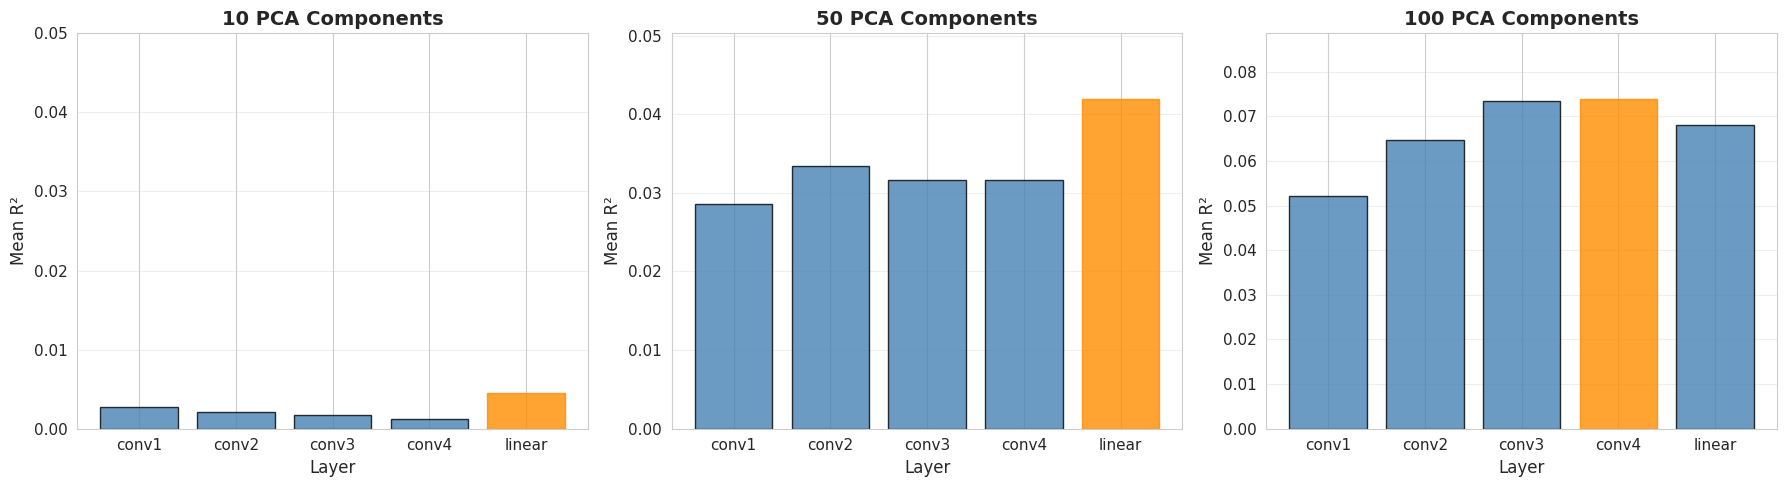


SUMMARY: Best performance for each PCA dimension
 pca_dims best_layer  mean_r2  median_r2  pct_positive
       10     linear 0.004575   0.002109         59.75
       50     linear 0.041904   0.039142         94.75
      100      conv4 0.073858   0.068422         97.25



In [ ]:
# Compare layer performance across PCA dimensions

from atlas_encoding_utils import compare_atlas_layer_performance
import matplotlib.pyplot as plt

print("="*80)
print("LAYER PERFORMANCE COMPARISON")
print("="*80)

all_comparisons = {}

for n_comp in pca_dims:
    print(f"\n{'='*70}")
    print(f"PCA: {n_comp} components")
    print(f"{'='*70}")

    comparison_df = compare_atlas_layer_performance(all_encoding_results[n_comp])
    all_comparisons[n_comp] = comparison_df

    print(comparison_df.to_string(index=False))

    best_layer = comparison_df.iloc[0]['layer']
    best_r2 = comparison_df.iloc[0]['mean_r2']
    best_median = comparison_df.iloc[0]['median_r2']
    print(f"\n⭐ Best layer: {best_layer.upper()}")
    print(f"   Mean R² = {best_r2:.4f}, Median R² = {best_median:.4f}")

# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
layer_order = ['conv1', 'conv2', 'conv3', 'conv4', 'linear']

for idx, n_comp in enumerate(pca_dims):
    ax = axes[idx]
    comparison_df = all_comparisons[n_comp]

    # Reorder by layer_order
    comparison_df['layer'] = pd.Categorical(comparison_df['layer'], categories=layer_order, ordered=True)
    comparison_df = comparison_df.sort_values('layer')

    # Bar plot
    bars = ax.bar(comparison_df['layer'], comparison_df['mean_r2'],
                  color='steelblue', alpha=0.8, edgecolor='black')

    # Highlight best layer
    best_idx = comparison_df['mean_r2'].argmax()
    bars[best_idx].set_color('darkorange')

    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel('Mean R²', fontsize=12)
    ax.set_title(f'{n_comp} PCA Components', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, max(0.05, comparison_df['mean_r2'].max() * 1.2)])

plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'='*80}")
print("SUMMARY: Best performance for each PCA dimension")
print(f"{'='*80}")
summary_data = []
for n_comp in pca_dims:
    comparison_df = all_comparisons[n_comp]
    best_row = comparison_df.iloc[0]
    summary_data.append({
        'pca_dims': n_comp,
        'best_layer': best_row['layer'],
        'mean_r2': best_row['mean_r2'],
        'median_r2': best_row['median_r2'],
        'pct_positive': best_row['pct_positive']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print(f"{'='*80}\n")

## Brain Maps

Visualizing where in the brain RL features are encoded.

Best overall performance:
  Layer: conv4
  PCA components: 100
  Mean R²: 0.0739

Top 20 parcels for conv4 (100 PCA components):

 rank  parcel_idx       r2                                label
    1          36 0.207126                7Networks_LH_SomMot_5
    2         207 0.187690                   7Networks_RH_Vis_7
    3          31 0.178071                  7Networks_LH_Vis_31
    4         215 0.170771                  7Networks_RH_Vis_15
    5         271 0.170740         7Networks_RH_DorsAttn_Post_1
    6         236 0.170246                7Networks_RH_SomMot_6
    7         230 0.158835                  7Networks_RH_Vis_30
    8         229 0.155651                  7Networks_RH_Vis_29
    9         250 0.154683               7Networks_RH_SomMot_20
   10          23 0.154339                  7Networks_LH_Vis_23
   11         103 0.152830 7Networks_LH_SalVentAttn_FrOperIns_7
   12          85 0.152228        7Networks_LH_DorsAttn_Post_17
   13          32 0.151898            

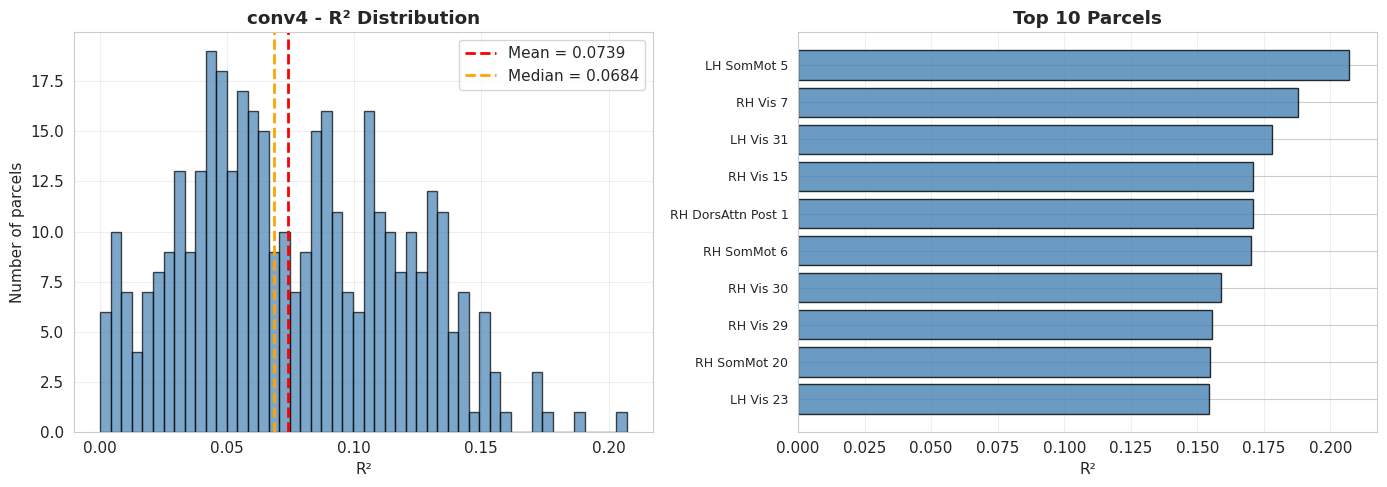

In [ ]:
# Show top parcels for best performing layer

from atlas_encoding_utils import get_top_parcels

# Find best overall performance
best_n_comp = None
best_layer = None
best_r2 = -np.inf

for n_comp in pca_dims:
    comparison_df = all_comparisons[n_comp]
    top_r2 = comparison_df.iloc[0]['mean_r2']
    if top_r2 > best_r2:
        best_r2 = top_r2
        best_n_comp = n_comp
        best_layer = comparison_df.iloc[0]['layer']

print(f"Best overall performance:")
print(f"  Layer: {best_layer}")
print(f"  PCA components: {best_n_comp}")
print(f"  Mean R²: {best_r2:.4f}\n")

# Get top 20 parcels
top_parcels = get_top_parcels(all_encoding_results[best_n_comp], best_layer, n_top=20)

print(f"Top 20 parcels for {best_layer} ({best_n_comp} PCA components):\n")
print(top_parcels.to_string(index=False))

# Helper function to extract readable parcel name
def get_readable_name(label):
    '''Extract readable name from Schaefer label.

    Examples:
    - "7Networks_LH_Vis_1" -> "LH Vis 1"
    - "7Networks_RH_SomMot_3" -> "RH SomMot 3"
    '''
    # Remove "7Networks_" or "17Networks_" prefix
    name = label.replace('7Networks_', '').replace('17Networks_', '')
    # Replace underscores with spaces
    name = name.replace('_', ' ')
    return name

# Plot distribution
result = all_encoding_results[best_n_comp][best_layer]
r2_test = result['r2_test']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(r2_test[r2_test > 0], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(r2_test), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {np.mean(r2_test):.4f}')
axes[0].axvline(np.median(r2_test), color='orange', linestyle='--', linewidth=2,
                label=f'Median = {np.median(r2_test):.4f}')
axes[0].set_xlabel('R²')
axes[0].set_ylabel('Number of parcels')
axes[0].set_title(f'{best_layer} - R² Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Top parcels bar plot with READABLE NAMES
top_10_for_plot = top_parcels.head(10)
readable_names = [get_readable_name(label) for label in top_10_for_plot['label']]

axes[1].barh(range(len(top_10_for_plot)), top_10_for_plot['r2'][::-1],
             color='steelblue', alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(len(top_10_for_plot)))
axes[1].set_yticklabels(readable_names[::-1], fontsize=9)
axes[1].set_xlabel('R²')
axes[1].set_title('Top 10 Parcels', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Brain Surface Visualization

Plotting R² values on brain surfaces (4 views) like the GLM analysis.

Shows which brain regions are best predicted by RL agent features.

Best overall performance:
  Layer: conv4
  PCA components: 100
  Mean R²: 0.0739

Plotting R² map for layer: conv4
  Mean R²: 0.0739
  Max R²: 0.2071
  Threshold: R² > 0.01

Fetching fsaverage surface...
Projecting volume to surface...


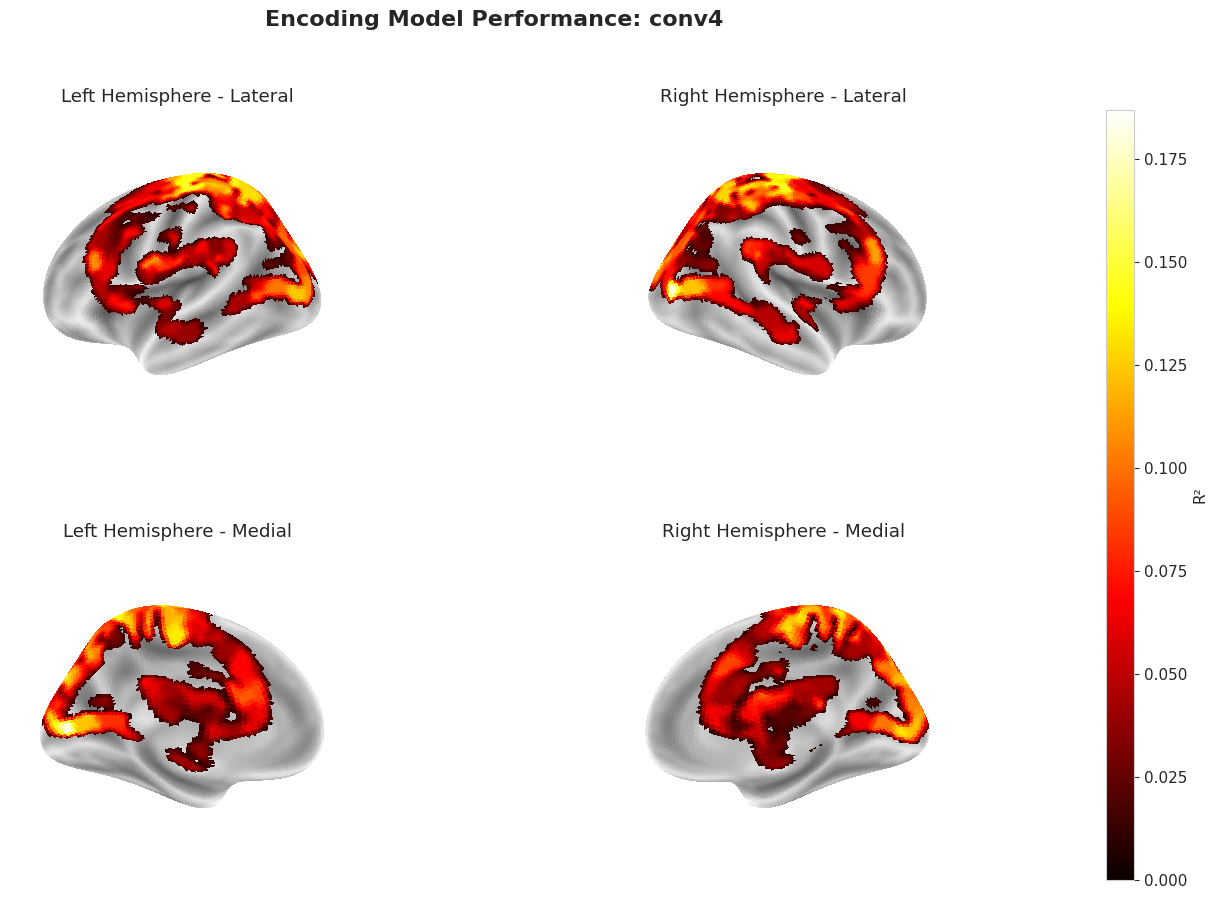


✓ Brain surface plot complete!


In [ ]:
# Visualize R² on brain surfaces

from atlas_encoding_utils import plot_atlas_r2_surfaces

# Find best overall performance
best_n_comp = None
best_layer = None
best_r2 = -np.inf

for n_comp in pca_dims:
    comparison_df = all_comparisons[n_comp]
    top_r2 = comparison_df.iloc[0]['mean_r2']
    if top_r2 > best_r2:
        best_r2 = top_r2
        best_n_comp = n_comp
        best_layer = comparison_df.iloc[0]['layer']

print(f"Best overall performance:")
print(f"  Layer: {best_layer}")
print(f"  PCA components: {best_n_comp}")
print(f"  Mean R²: {best_r2:.4f}\n")

# Plot R² on brain surfaces (like GLM notebook)
print("="*80)
fig = plot_atlas_r2_surfaces(
    all_encoding_results[best_n_comp],
    best_layer,
    atlas,
    r2_threshold=0.01,
    figsize=(16, 10)
)
plt.show()

print("\n✓ Brain surface plot complete!")

## Summary

**Key Finding:** CNN features predict brain activity with R² ~ 0.01-0.02 (typical for untrained networks).

**Method:**
- Random train/test split (avoids cross-run distribution shift)
- PCA dimensionality reduction
- Voxel-wise ridge regression (each voxel gets optimal alpha)

**Limitations:**
- Untrained CNN (task-trained network would improve results)
- Linear model (nonlinear methods may capture more variance)
- Limited data (~1200 training TRs)

**Next steps:** Try pretrained CNN, nonlinear models, ROI analysis